# Playground Notebook For Quantizing VLP Models

In [1]:
# Suppress specific warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# General imports
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from typing import Dict, List, Tuple, Optional
import pytorch_lightning as pl
from sacred import Experiment

# Suppress specific warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


from vilt.modules import ViLTransformerSS
from meter.modules import METERTransformerSS
from vilt.datamodules.multitask_datamodule import MTDataModule as MTDataModuleVILT
from meter.datamodules.multitask_datamodule import MTDataModule as MTDataModuleMETER
from quantization_utils import (
    get_quantization_config,
    SmallMTDataModuleVILT,
    SmallMTDataModuleMETER,
    quantize_modules
)

/home/mileriso/envs/.py10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Analyzer Class

In [6]:
class ModelAnalyzer():
    def __init__(self, config: dict, model_type: str = "vilt", num_samples: int = 100) -> None:
        self.config = config
        self.model_type = model_type
        self.device = "cpu"
        self.num_samples = num_samples
        
        # Initialize the model and dataset
        self.get_model(self.config, self.model_type, self.num_samples)

        # Create output directory
        self.output_dir = f"analysis_results/{model_type}"
        os.makedirs(self.output_dir, exist_ok=True)
        
    def get_model(self, config: dict, model_type: str, num_samples: int = 100) -> None:
        if model_type == "meter":
            self.model = METERTransformerSS(config).to(self.device)
            self.dm = SmallMTDataModuleMETER(config, dist=False, num_samples=100)
        elif model_type == "vilt":
            self.model = ViLTransformerSS(config).to(self.device)
            self.dm = SmallMTDataModuleVILT(config, dist=False, num_samples=100)
        else:
            raise ValueError(f"Model type {model_type} not supported.")
            
        self.dm.setup("test")
        self.dataloader = self.dm.test_dataloader()
    
    def _get_layer_weights(self, model: torch.nn.Module, layer_name: str) -> torch.Tensor:
        """Helper function to get layer weights"""
        # First try to find the exact layer name
        for name, param in model.named_parameters():
            if layer_name in name and "weight" in name:
                return param.data
                
        # If not found, try to find the quantized version
        for name, module in model.named_modules():
            if layer_name in name:
                # Check if this is a quantized module with packed params
                if hasattr(module, '_packed_params'):
                    # For quantized modules, we need to call weight() as a function
                    return module.weight().data
                # If not quantized, try to find weight parameter directly
                for param_name, param in module.named_parameters():
                    if "weight" in param_name:
                        return param.data
                        
        # If still not found, print available layers for debugging
        print("Available layers in model:")
        for name, _ in model.named_modules():
            print(f"  {name}")
            
        raise ValueError(f"Layer {layer_name} not found in model")

    def _get_layer_activations(self, model: torch.nn.Module, batch: Dict, layer_name: str) -> torch.Tensor:
        activations = []
        
        def hook_fn(module, input, output):
            activations.append(output)
        
        # Register hook to the layer
        for name, module in model.named_modules():
            if layer_name in name:
                hook = module.register_forward_hook(hook_fn)
                break
        
        # Forward pass
        _ = model(batch)
        # Remove hook
        hook.remove()
        
        return activations[0]

    def analyze_weight_distributions(self, layer_name: str, precision: int = 4) -> Dict:
        """Analyze weight distributions before and after quantization"""
        
        # Create quantized model
        model_quant = deepcopy(self.model)
        model_quant = quantize_modules(model_quant, [layer_name], precision)
        
        # Get weights
        weights_orig = self._get_layer_weights(self.model, layer_name)
        weights_quant = self._get_layer_weights(model_quant, layer_name)
        
        # Calculate statistics
        stats = {
            "original": {
                "mean": weights_orig.mean().item(),
                "std": weights_orig.std().item(),
                "min": weights_orig.min().item(),
                "max": weights_orig.max().item()
            },
            "quantized": {
                "min": weights_quant.min().item(),
                "max": weights_quant.max().item(),
                "dtype": str(weights_quant.dtype)
            }
        }
        
        return stats, weights_orig, weights_quant, layer_name
    
    def analyze_activation_distributions(self, layer_name: str, precision: int = 4) -> Dict:
        """Analyze activation distributions before and after quantization"""
        
        # Create quantized model
        model_quant = deepcopy(self.model)
        model_quant = quantize_modules(model_quant, [layer_name], precision)
        
        # Get activations
        self.model.eval()
        model_quant.eval()
        
        activations_orig = []
        activations_quant = []
        
        with torch.no_grad():
            for batch in self.dataloader:
                # Move batch to device
                batch = {k: v.to(self.device) if isinstance(v, torch.Tensor) else v 
                        for k, v in batch.items()}
                
                # Get original activations
                orig_acts = self._get_layer_activations(self.model, batch, layer_name)
                # Take mean across sequence dimension to handle variable lengths
                orig_acts = orig_acts.mean(dim=1)  # [batch_size, hidden_dim]
                activations_orig.append(orig_acts)
                
                # Get quantized activations
                quant_acts = self._get_layer_activations(model_quant, batch, layer_name)
                # Take mean across sequence dimension
                quant_acts = quant_acts.mean(dim=1)  # [batch_size, hidden_dim]
                activations_quant.append(quant_acts)
        
        # Concatenate activations
        activations_orig = torch.cat(activations_orig, dim=0)
        activations_quant = torch.cat(activations_quant, dim=0)
        
        # Calculate statistics
        stats = {
            "original": {
                "mean": activations_orig.mean().item(),
                "std": activations_orig.std().item(),
                "min": activations_orig.min().item(),
                "max": activations_orig.max().item()
            },
            "quantized": {
                "mean": activations_quant.mean().item(),
                "std": activations_quant.std().item(),
                "min": activations_quant.min().item(),
                "max": activations_quant.max().item()
            }
        }
        
        return stats, activations_orig, activations_quant, layer_name


def plot_weight_distributions(weights_orig: torch.Tensor, layer_name: str, output_dir: str):
    """Plot weight distributions"""
    plt.figure(figsize=(10, 6))
    
    # Plot original weights
    sns.histplot(weights_orig.cpu().numpy().flatten(), 
                label="Original", alpha=0.5)
    
    plt.title(f"Weight Distribution: {layer_name}")
    plt.xlabel("Weight Value")
    plt.ylim(10000)
    plt.ylabel("Count")
    plt.legend()
    plt.show()
    
    # # Save plot
    # plt.savefig(os.path.join(output_dir, f"weights_{layer_name.replace('.', '_')}.png"))
    # plt.close()

def plot_activation_distributions(activations_orig: torch.Tensor, layer_name: str, output_dir: str):
    """Plot activation distributions"""
    plt.figure(figsize=(10, 6))
    
    # Plot original activations
    sns.histplot(activations_orig.cpu().numpy().flatten(),
                label="Original", alpha=0.5)
    
    # # Plot quantized activations
    # sns.histplot(activations_quant.cpu().numpy().flatten(),
    #             label="Quantized", alpha=0.5)
    
    plt.title(f"Activation Distribution: {layer_name}")
    plt.xlabel("Activation Value")
    plt.ylabel("Count")
    # plt.legend()
    plt.show()
    
    # # Save plot
    # plt.savefig(os.path.join(output_dir, f"activations_{layer_name.replace('.', '_')}.png"))
    # plt.close()

# Configurations

In [3]:
# Initialize configurations
from configs import meter_config_nlvr2, vilt_config_nlvr2

# Create output directory
os.makedirs("analysis_results", exist_ok=True)

# Analyze METER model
print("Analyzing METER model...")
meter_analyzer = ModelAnalyzer(meter_config_nlvr2, "meter")

# Analyze sensitive layers
sensitive_layers = [
    "text_transformer.encoder.layer.2.intermediate.dense",
    "text_transformer.encoder.layer.2.output.dense"
]

meter_results = {}
for layer in sensitive_layers:
    print(f"\nAnalyzing layer: {layer}")
    
    # Weight distribution analysis
    weight_stats_meter, weights_orig_meter, weights_quant_meter, layer_name_meter = meter_analyzer.analyze_weight_distributions(layer)
    print(f"Weight Statistics:\n{weight_stats_meter}")
    
    # Activation distribution analysis
    activation_stats_meter, activations_orig_meter, activations_quant_meter, layer_name_meter = meter_analyzer.analyze_activation_distributions(layer)
    print(f"Activation Statistics:\n{activation_stats_meter}")
    
    meter_results[layer] = {
        "weight_stats": weight_stats_meter,
        "activation_stats": activation_stats_meter,
    }

# Analyze ViLT model
print("\nAnalyzing ViLT model...")
vilt_analyzer = ModelAnalyzer(vilt_config_nlvr2, "vilt")

# Analyze sensitive layers
sensitive_layers = [
    "transformer.blocks.0.mlp.fc1",
    "transformer.blocks.0.mlp.fc2"
]

vilt_results = {}
for layer in sensitive_layers:
    print(f"\nAnalyzing layer: {layer}")
    
    # Weight distribution analysis
    weight_stats_vilt, weights_orig_vilt, weights_quant_vilt, layer_name_vilt = vilt_analyzer.analyze_weight_distributions(layer)
    print(f"Weight Statistics:\n{weight_stats_vilt}")
    
    # Activation distribution analysis
    activation_stats_vilt, activations_orig_vilt, activations_quant_vilt, layer_name_vilt = vilt_analyzer.analyze_activation_distributions(layer)
    print(f"Activation Statistics:\n{activation_stats_vilt}")
    
    vilt_results[layer] = {
        "weight_stats": weight_stats_vilt,
        "activation_stats": activation_stats_vilt,
    }

# Save results
import json
with open("analysis_results/meter_results.json", "w") as f:
    json.dump(meter_results, f, indent=4)
with open("analysis_results/vilt_results.json", "w") as f:
    json.dump(vilt_results, f, indent=4)

Analyzing METER model...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded names: ['nlvr2_vlue_test']
Loaded names: ['nlvr2_vlue_test']
Loaded names: ['nlvr2_vlue_test']

Analyzing layer: text_transformer.encoder.layer.2.intermediate.dense
Weight Statistics:
{'original': {'mean': -0.009900933131575584, 'std': 0.06082366406917572, 'min': -0.6395875811576843, 'max': 0.645700216293335}, 'quantized': {'min': -0.6026535034179688, 'max': 0.6026535034179688, 'dtype': 'torch.qint8'}}
Activation Statistics:
{'original': {'mean': -1.5249650478363037, 'std': 0.8616282343864441, 'min': -9.155832290649414, 'max': 4.385232925415039}, 'quantized': {'mean': -1.2024638652801514, 'std': 0.9947346448898315, 'min': -9.900171279907227, 'max': 5.615255832672119}}

Analyzing layer: text_transformer.encoder.layer.2.output.dense
Weight Statistics:
{'original': {'mean': 2.1752925022155978e-05, 'std': 0.04810984432697296, 'min': -0.9618302583694458, 'max': 0.9973081350326538}, 'quantized': {'min': -0.9308209419250488, 'max': 0.9308209419250488, 'dtype': 'torch.qint8'}}
Activatio

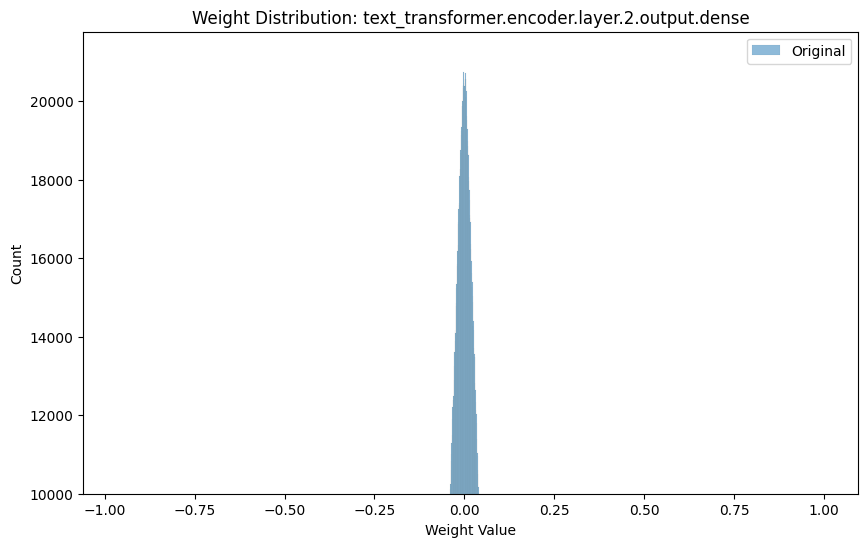

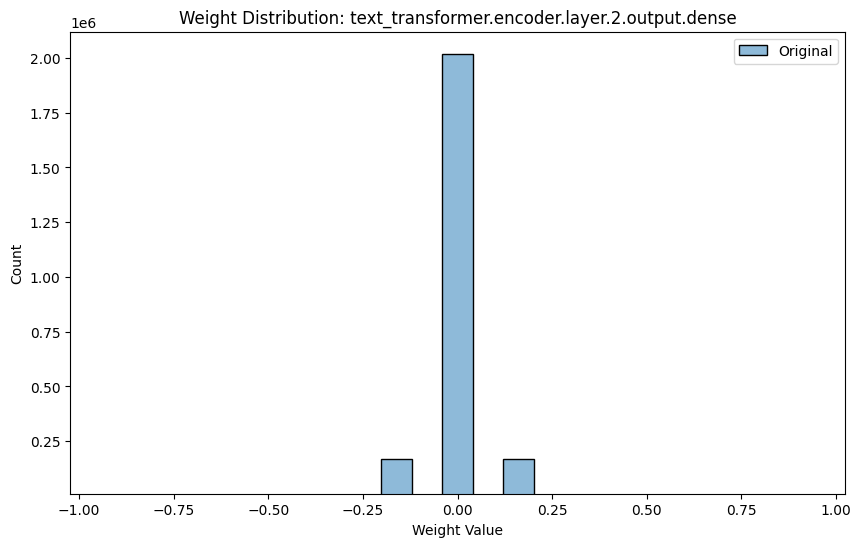

In [7]:
plot_weight_distributions(weights_orig_meter, layer_name_meter, meter_analyzer.output_dir)
plot_weight_distributions(weights_quant_meter.dequantize(), layer_name_meter, meter_analyzer.output_dir)

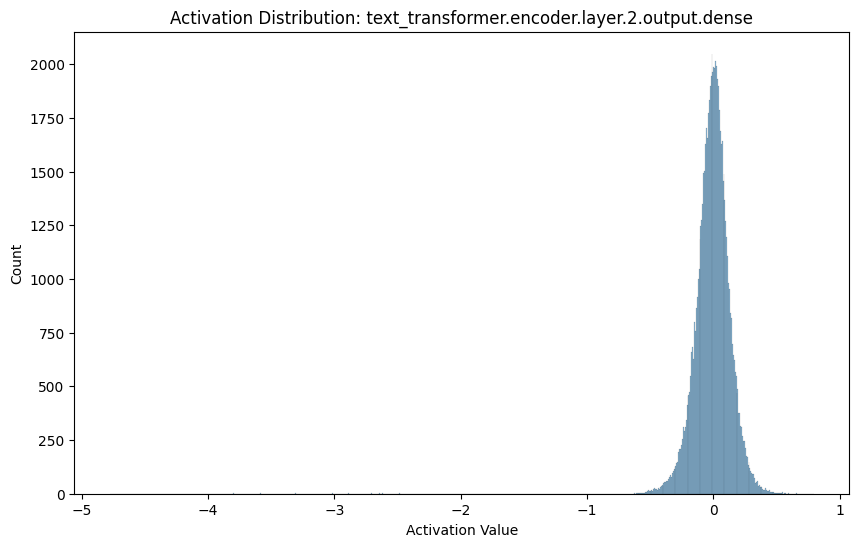

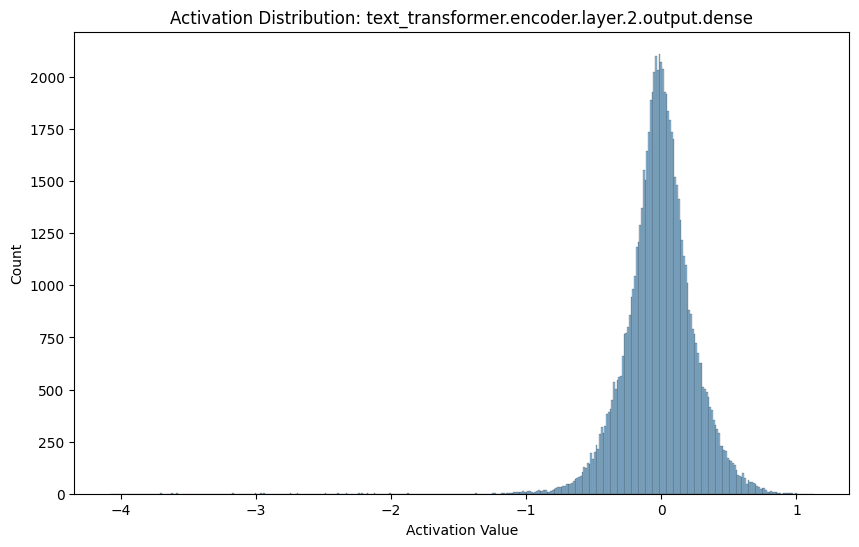

In [8]:
plot_activation_distributions(activations_orig_meter, layer_name_meter, meter_analyzer.output_dir)
plot_activation_distributions(activations_quant_meter, layer_name_meter, meter_analyzer.output_dir)

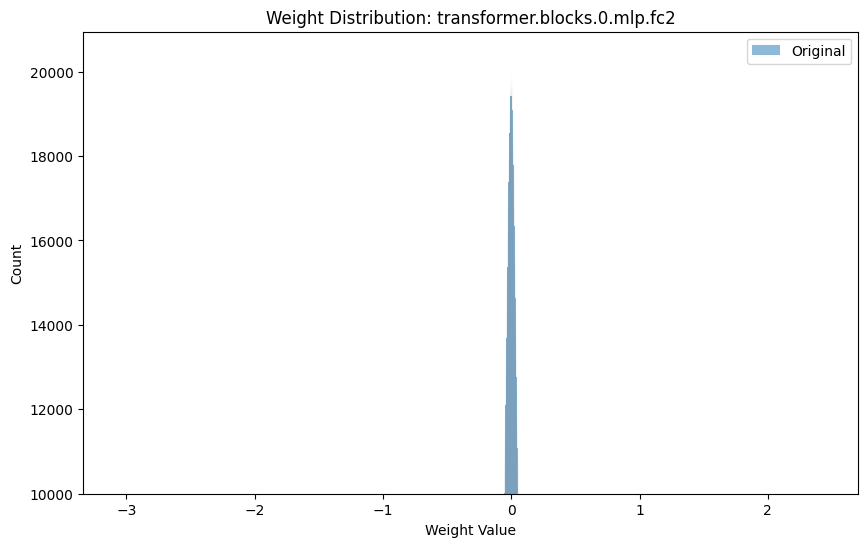

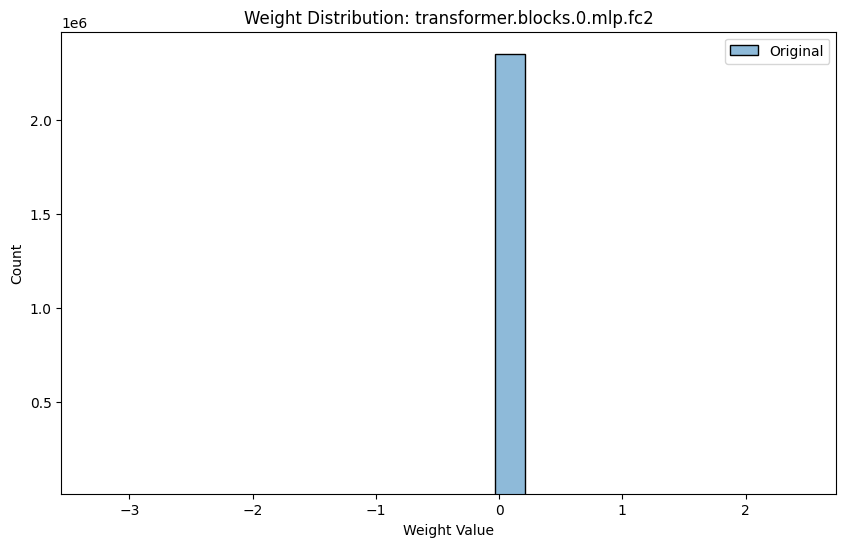

In [11]:
plot_weight_distributions(weights_orig_vilt, layer_name_vilt, vilt_analyzer.output_dir)
plot_weight_distributions(weights_quant_vilt.dequantize(), layer_name_vilt, vilt_analyzer.output_dir)

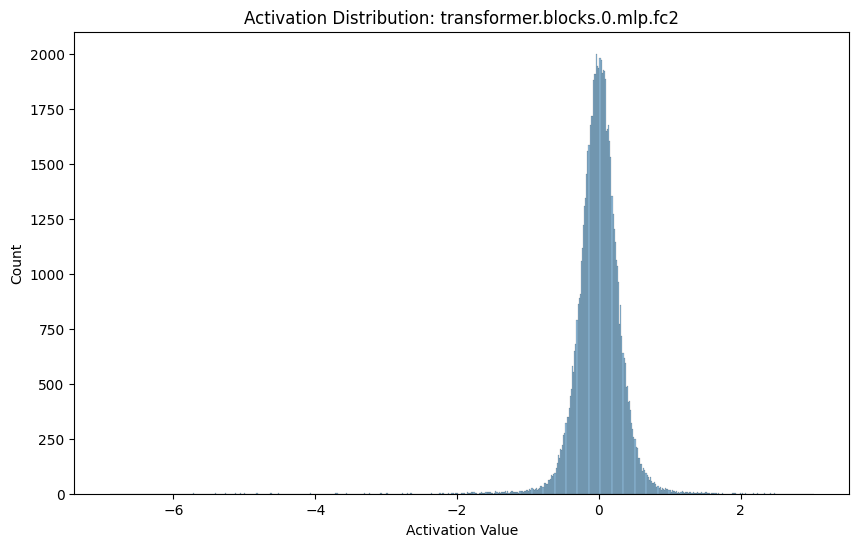

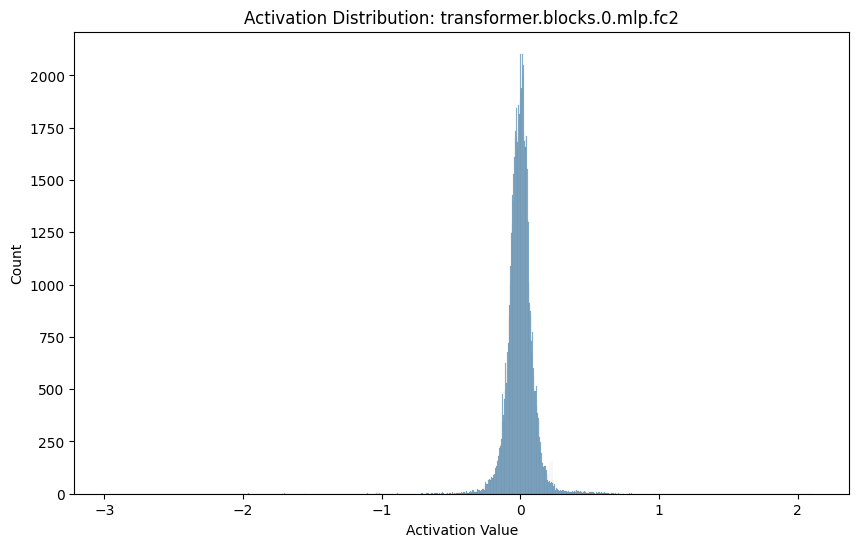

In [12]:
plot_activation_distributions(activations_orig_vilt, layer_name_vilt, vilt_analyzer.output_dir)
plot_activation_distributions(activations_quant_vilt, layer_name_vilt, vilt_analyzer.output_dir)

In [14]:
# Set the configuration
import configs
vilt_config = configs.vilt_config_nlvr2
meter_config = configs.meter_config_nlvr2

vilt_config["batch_size"] = 10
vilt_config["per_gpu_batchsize"] = 2
vilt_config["learning_rate"] = 0.001

meter_config["batch_size"] = 10
meter_config["per_gpu_batchsize"] = 2
meter_config["learning_rate"] = 0.001

grad_steps = meter_config["batch_size"] // (
        meter_config["per_gpu_batchsize"]
    )

print("Grad steps: ", grad_steps)


# Set the PyTorch Lightning seed
pl.seed_everything(meter_config["seed"])

# Limit the number of CPUs
os.environ["OMP_NUM_THREADS"] = "10"  # Set this to the number of CPUs you want to use
os.environ["MKL_NUM_THREADS"] = "10"  # Set this to the number of CPUs you want to use

# Set environment variables
os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '12355'

Seed set to 0


Grad steps:  5


## Initialize Distributed Backend

In [15]:
import torch.distributed as dist
# Initialize the process group
dist.init_process_group(backend='gloo', init_method='env://', world_size=1, rank=0)

# Verify initialization
print(f"Initialized: {dist.is_initialized()}")

Initialized: True


# Initialize the Datamodule

In [16]:
meter_test_dm = SmallMTDataModuleMETER(meter_config, dist=False, num_samples=50)
meter_test_dm.setup("test", is_random=True)
meter_test_dataloader = meter_test_dm.test_dataloader()

vilt_test_dm = SmallMTDataModuleVILT(vilt_config, dist=False, num_samples=50)
vilt_test_dm.setup("test", is_random=True)
vilt_test_dataloader = vilt_test_dm.test_dataloader()

print(f"Batch size: {meter_config['batch_size']}")
print(f"Lenght of the METER dataloader: {len(meter_test_dataloader)}")
print(f"Length of the ViLT dataloader: {len(vilt_test_dataloader)}")

Loaded names: ['nlvr2_vlue_test']
Loaded names: ['nlvr2_vlue_test']
Loaded names: ['nlvr2_vlue_test']
Batch size: 10
Lenght of the METER dataloader: 25
Length of the ViLT dataloader: 25


# Initialize The Model

In [17]:
meter_model = METERTransformerSS(meter_config)
vilt_model = ViLTransformerSS(vilt_config)
print("Models created")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Models created


# Analyzer Class

In [ ]:
class Analyzer():
    def __init__(self, meter_model, vilt_model):
        self.meter_model = meter_model
        self.vilt_model = vilt_model
        self.meter_feats = None
        self.vilt_feats = None
    
    def _register_hooks_meter(self, kd_layer):
        """ Registers hooks to capture the fusion block outputs. """
        def student_hook(module, inp, out):
            self.meter_feats = out[0]

        self.meter_model.text_transformer.encoder.layer[kd_layer].register_forward_hook(student_hook)
    
    def _register_hooks_vilt(self, kd_layer):
        """ Registers hooks to capture the fusion block outputs. """
        def student_hook(module, inp, out):
            self.vilt_feats = out[0]

        self.vilt_model.transformer.blocks[kd_layer].register_forward_hook(student_hook)
    
    def _get_weights(self, model: torch.nn.Module, layer_name: str) -> torch.Tensor:
        """Helper function to get layer weights"""
        # First try to find the exact layer name
        for name, param in model.named_parameters():
            if layer_name in name and "weight" in name:
                return param.data
                
        # If not found, try to find the quantized version
        for name, module in model.named_modules():
            if layer_name in name:
                # Check if this is a quantized module with packed params
                if hasattr(module, '_packed_params'):
                    # For quantized modules, we need to call weight() as a function
                    return module.weight().data
                # If not quantized, try to find weight parameter directly
                for param_name, param in module.named_parameters():
                    if "weight" in param_name:
                        return param.data
                        
        # If still not found, print available layers for debugging
        print("Available layers in model:")
        for name, _ in model.named_modules():
            print(f"  {name}")
            
        raise ValueError(f"Layer {layer_name} not found in model")

    def _get_layer_activations(self, model: torch.nn.Module, batch: Dict, layer_name: str) -> torch.Tensor:
        activations = []
        
        def hook_fn(module, input, output):
            activations.append(output)
        
        # Register hook to the layer
        for name, module in model.named_modules():
            if layer_name in name:
                hook = module.register_forward_hook(hook_fn)
                break
        
        # Forward pass
        _ = model(batch)
        # Remove hook
        hook.remove()
        
        return activations[0]
    
    def _is_hooked(self):
        return self.meter_feats is not None and self.vilt_feats is not None
    
    def forward(self, meter_model, vilt_model, meter_batch, vilt_batch):
        print("Forwarding the models")
        with torch.no_grad():
            print("Meter model")
            print("Image token type 1")
            meter_model.infer(meter_batch, mask_text=False, mask_image=False, image_token_type_idx=1)
            print("Image token type 2")
            meter_model.infer(meter_batch, mask_text=False, mask_image=False, image_token_type_idx=2)
            
            print("VILT model")
            print("Image token type 1")
            vilt_model.infer(vilt_batch, mask_text=False, mask_image=False, image_token_type_idx=1)
            print("Image token type 2")
            vilt_model.infer(vilt_batch, mask_text=False, mask_image=False, image_token_type_idx=2)
        
        if not self._is_hooked():
            raise ValueError("Hooks not registered")
    
    def analyze_outputs(self, print_stats=True, plot=True):
        """Analyze and visualize the output distributions from both models"""
        import matplotlib.pyplot as plt
        import numpy as np
        import seaborn as sns
        
        if not self._is_hooked():
            raise ValueError("No outputs captured. Run forward() first.")
        
        # Get the tensor data and convert to numpy for analysis
        meter_data = self.meter_feats.detach().cpu().numpy().flatten()
        vilt_data = self.vilt_feats.detach().cpu().numpy().flatten()
        
        # Compute basic statistics
        meter_stats = {
            'mean': np.mean(meter_data),
            'std': np.std(meter_data),
            'min': np.min(meter_data),
            'max': np.max(meter_data),
            'abs_mean': np.mean(np.abs(meter_data)),
        }
        
        vilt_stats = {
            'mean': np.mean(vilt_data),
            'std': np.std(vilt_data),
            'min': np.min(vilt_data),
            'max': np.max(vilt_data),
            'abs_mean': np.mean(np.abs(vilt_data)),
        }
        
        # Print statistics if requested
        if print_stats:
            print("METER output statistics:")
            for k, v in meter_stats.items():
                print(f"  {k}: {v:.6f}")
            
            print("\nViLT output statistics:")
            for k, v in vilt_stats.items():
                print(f"  {k}: {v:.6f}")
            
            # Compute scale factor between distributions
            scale_ratio = vilt_stats['abs_mean'] / meter_stats['abs_mean'] if meter_stats['abs_mean'] > 0 else 0
            print(f"\nEstimated scale factor (ViLT/METER): {scale_ratio:.6f}")
            
            # If ViLT has a scale_factor parameter, print it
            if hasattr(self.vilt_model, 'scale_factor'):
                print(f"Current ViLT scale_factor parameter: {self.vilt_model.scale_factor.item():.6f}")
        
        # Plot distributions if requested
        if plot:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
            
            # Plot METER distribution
            sns.histplot(meter_data, ax=ax1, kde=True, stat="density", label="METER")
            ax1.set_title("METER Output Distribution")
            ax1.set_xlabel("Value")
            ax1.set_ylabel("Density")
            
            # Plot ViLT distribution
            sns.histplot(vilt_data, ax=ax2, kde=True, stat="density", label="ViLT")
            ax2.set_title("ViLT Output Distribution")
            ax2.set_xlabel("Value")
            
            # Plot both on same axes for comparison
            sns.histplot(meter_data, ax=ax3, kde=True, stat="density", label="METER", alpha=0.5)
            sns.histplot(vilt_data, ax=ax3, kde=True, stat="density", label="ViLT", alpha=0.5)
            ax3.set_title("Comparison of Output Distributions")
            ax3.set_xlabel("Value")
            ax3.legend()
            
            plt.tight_layout()
            plt.show()
            
            # # Plot 2D distribution comparison
            # fig, ax = plt.subplots(figsize=(10, 8))
            # percentiles = np.linspace(0, 100, 100)
            # meter_percentiles = np.percentile(meter_data, percentiles)
            # vilt_percentiles = np.percentile(vilt_data, percentiles)
            
            # ax.scatter(meter_percentiles, vilt_percentiles, alpha=0.5)
            # ax.plot([min(meter_percentiles), max(meter_percentiles)],
            #         [min(meter_percentiles), max(meter_percentiles)], 
            #         'r--', label="y=x")
            
            # ax.set_xlabel("METER Output Percentiles")
            # ax.set_ylabel("ViLT Output Percentiles")
            # ax.set_title("Q-Q Plot: METER vs ViLT Outputs")
            # ax.legend()
            
            # plt.tight_layout()
            # plt.show()
            
        return meter_stats, vilt_stats
    
    def analyze_scale_factor_impact(self, model, batch, model_type="vilt", scale_values=[0.5, 1.0, 2.0, 5.0], 
                                    custom_forward=None, model_name=None):
        """
        Analyze how different scale_factor values impact the output distribution
        
        Args:
            model: The model to analyze
            batch: Input batch for the model
            model_type: Either "meter" or "vilt" to determine which feature variable to use
            scale_values: List of scale factor values to test
            custom_forward: Optional function to handle model forwarding (takes model and batch)
            model_name: Name to display in plots (defaults to model_type if not provided)
        """
        import matplotlib.pyplot as plt
        import numpy as np
        import seaborn as sns
        
        if model_name is None:
            model_name = model_type.upper()
        
        # Determine which feature variable to use
        if model_type.lower() == "meter":
            feature_attr = "meter_feats"
        elif model_type.lower() == "vilt":  
            feature_attr = "vilt_feats"
        else:
            raise ValueError(f"Unknown model_type: {model_type}. Use 'meter' or 'vilt'")
        
        # Store original scale factor value to restore later
        original_scale = None
        if hasattr(model, 'scale_factor'):
            original_scale = model.scale_factor.item()
        else:
            raise ValueError("Model does not have a scale_factor parameter")
        
        results = {}
        
        fig, axes = plt.subplots(len(scale_values), 2, figsize=(15, 5*len(scale_values)))
        
        for i, scale in enumerate(scale_values):
            # Set the scale factor
            with torch.no_grad():
                model.scale_factor.copy_(torch.tensor(scale))
                print(f"Set scale_factor to {scale}")
            
            # Clear previous hook data
            setattr(self, feature_attr, None)
            
            # Forward pass using either custom function or default approach
            with torch.no_grad():
                if custom_forward is not None:
                    custom_forward(model, batch)
                else:
                    model.infer(batch, mask_text=False, mask_image=False, image_token_type_idx=1)
            
            # Get the output data
            output_data = getattr(self, feature_attr).detach().cpu().numpy().flatten()
            
            # Store results
            results[scale] = {
                'mean': np.mean(output_data),
                'std': np.std(output_data),
                'min': np.min(output_data),
                'max': np.max(output_data),
                'abs_mean': np.mean(np.abs(output_data)),
                'data': output_data
            }
            
            # Plot distribution
            ax_row = axes[i] if len(scale_values) > 1 else axes
            
            sns.histplot(output_data, ax=ax_row[0], kde=True)
            ax_row[0].set_title(f"{model_name}, Scale={scale}: Distribution")
            
            # Plot boxplot
            sns.boxplot(x=output_data, ax=ax_row[1])
            ax_row[1].set_title(f"{model_name}, Scale={scale}: Box Plot")
            
        # Restore original scale factor if it existed
        if original_scale is not None:
            with torch.no_grad():
                model.scale_factor.copy_(torch.tensor(original_scale))
                print(f"Restored original scale_factor to {original_scale}")
        
        plt.tight_layout()
        plt.show()
        
        # Plot comparison of means and stds
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        scales = list(results.keys())
        means = [results[s]['mean'] for s in scales]
        stds = [results[s]['std'] for s in scales]
        abs_means = [results[s]['abs_mean'] for s in scales]
        
        ax1.plot(scales, means, 'o-', label='Mean')
        ax1.plot(scales, abs_means, 's-', label='Abs Mean')
        ax1.set_xlabel('Scale Factor')
        ax1.set_ylabel('Value')
        ax1.set_title(f'Effect of Scale Factor on {model_name} Mean Values')
        ax1.legend()
        
        ax2.plot(scales, stds, 'o-')
        ax2.set_xlabel('Scale Factor')
        ax2.set_ylabel('Standard Deviation')
        ax2.set_title(f'Effect of Scale Factor on {model_name} Standard Deviation')
        
        plt.tight_layout()
        plt.show()
        
        return results

In [21]:
# Get the first batch of data
meter_batch = next(iter(meter_test_dataloader))
vilt_batch = next(iter(vilt_test_dataloader))
analyzer = Analyzer(meter_model, vilt_model)

In [ ]:
def _get_weights(model: torch.nn.Module, layer_name: str) -> torch.Tensor:
    """Helper function to get layer weights"""
    # First try to find the exact layer name
    for name, param in model.named_parameters():
        if layer_name in name and "weight" in name:
            return param.data
            
    # If not found, try to find the quantized version
    for name, module in model.named_modules():
        if layer_name in name:
            # Check if this is a quantized module with packed params
            if hasattr(module, '_packed_params'):
                # For quantized modules, we need to call weight() as a function
                return module.weight().data
            # If not quantized, try to find weight parameter directly
            for param_name, param in module.named_parameters():
                if "weight" in param_name:
                    return param.data
                    
    # If still not found, print available layers for debugging
    print("Available layers in model:")
    for name, _ in model.named_modules():
        print(f"  {name}")
        
    raise ValueError(f"Layer {layer_name} not found in model")

def plot_weight_distributions(weights_orig_1: torch.Tensor, weights_orig_2: torch.Tensor, layer_name: str):
    """Plot weight distributions"""
    plt.figure(figsize=(10, 6))
    
    # Plot original weights
    sns.histplot(weights_orig_1.cpu().numpy().flatten(), 
                label="Original 1", alpha=0.5)
    sns.histplot(weights_orig_2.cpu().numpy().flatten(), 
                label="Original 2", alpha=0.5)
    
    plt.title(f"Weight Distribution: {layer_name}")
    plt.xlabel("Weight Value")
    plt.ylim(10000)
    plt.ylabel("Count")
    plt.legend()
    plt.show()

Forwarding the models
Meter model
Image token type 1
Image token type 2
VILT model
Image token type 1
Image token type 2
METER output statistics:
  mean: 0.022731
  std: 0.723141
  min: -12.305448
  max: 15.110385
  abs_mean: 0.284766

ViLT output statistics:
  mean: 11.319778
  std: 44.252396
  min: -2637.345215
  max: 1659.843872
  abs_mean: 19.722891

Estimated scale factor (ViLT/METER): 69.259972
Current ViLT scale_factor parameter: 1.000000


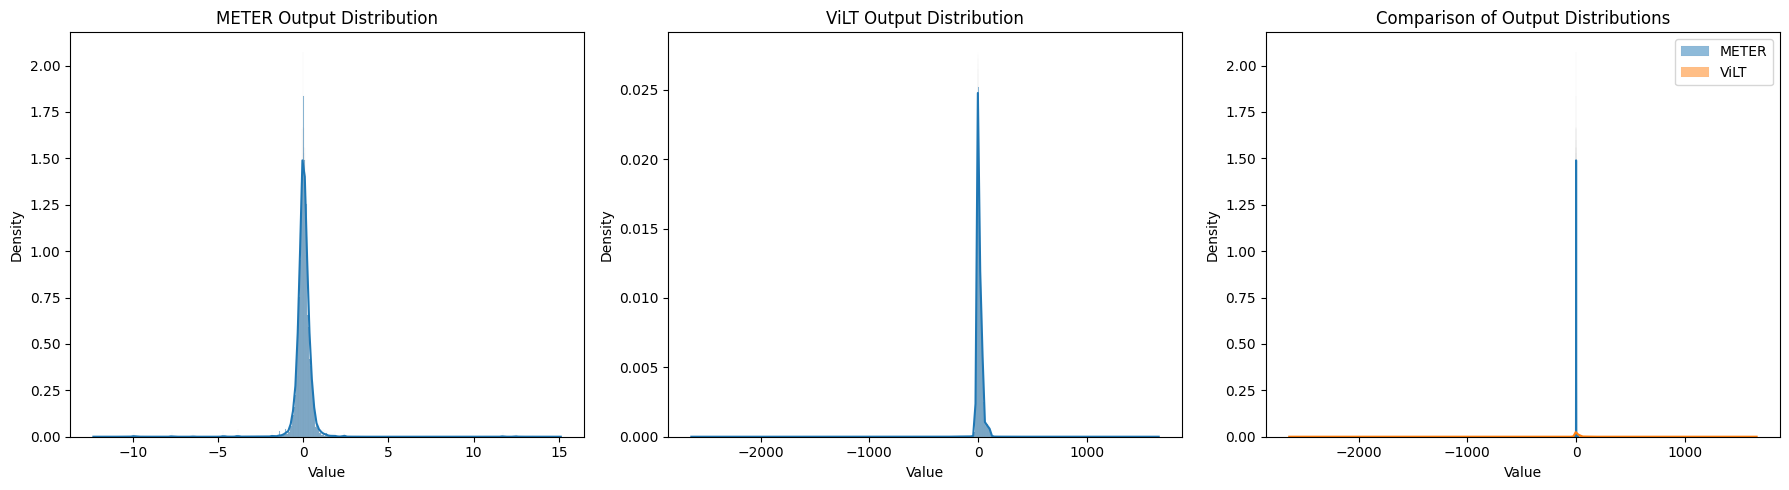

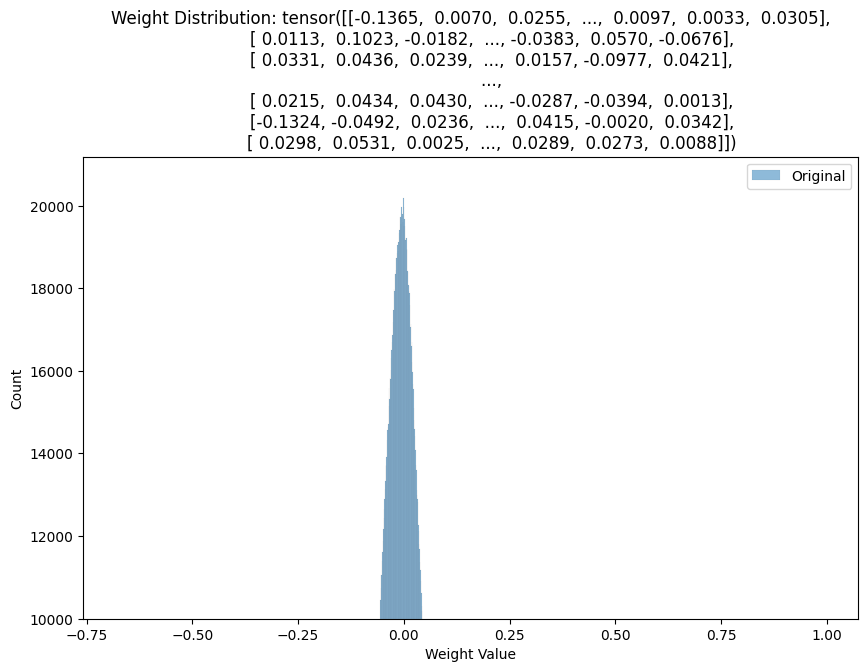

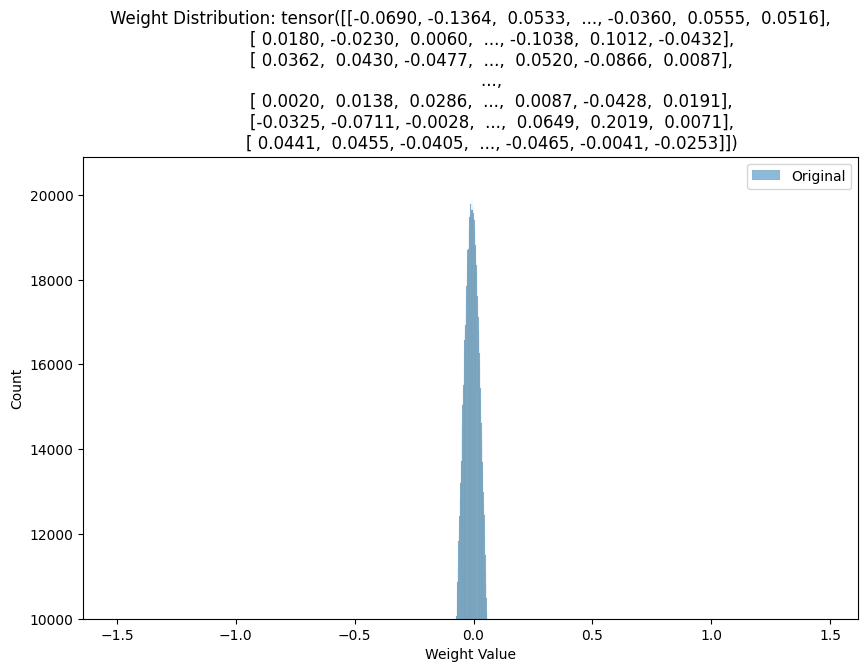

In [27]:
analyzer._register_hooks_meter(0)
analyzer._register_hooks_vilt(0)
analyzer.forward(meter_model, vilt_model, meter_batch, vilt_batch)
# Analyze and visualize the outputs
meter_stats, vilt_stats = analyzer.analyze_outputs()

meter_weights_intermediate = _get_weights(analyzer.meter_model, "text_transformer.encoder.layer.0.intermediate.dense")
meter_weights_output = _get_weights(analyzer.meter_model, "text_transformer.encoder.layer.0.output.dense")

vilt_weights_fc1 = _get_weights(analyzer.vilt_model, "transformer.blocks.0.mlp.fc1")
vilt_weights_fc2 = _get_weights(analyzer.vilt_model, "transformer.blocks.0.mlp.fc2")

plot_weight_distributions(meter_weights_intermediate, meter_weights_output, "METER")
plot_weight_distributions(vilt_weights_fc1, vilt_weights_fc2, "ViLT")

Forwarding the models
Meter model
Image token type 1
Image token type 2
VILT model
Image token type 1
Image token type 2
METER output statistics:
  mean: 0.022731
  std: 0.723141
  min: -12.305448
  max: 15.110385
  abs_mean: 0.284766

ViLT output statistics:
  mean: 11.670620
  std: 43.147198
  min: -3260.912598
  max: 1886.417969
  abs_mean: 20.283436

Estimated scale factor (ViLT/METER): 71.228416
Current ViLT scale_factor parameter: 1.000000


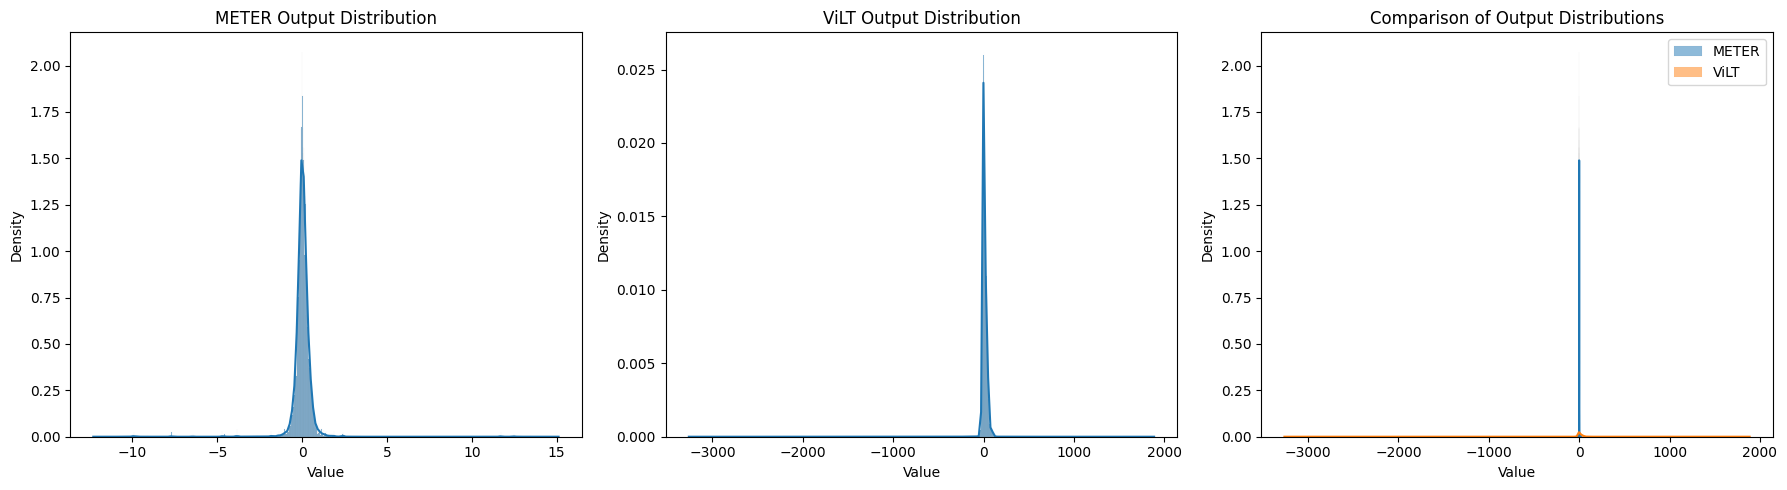

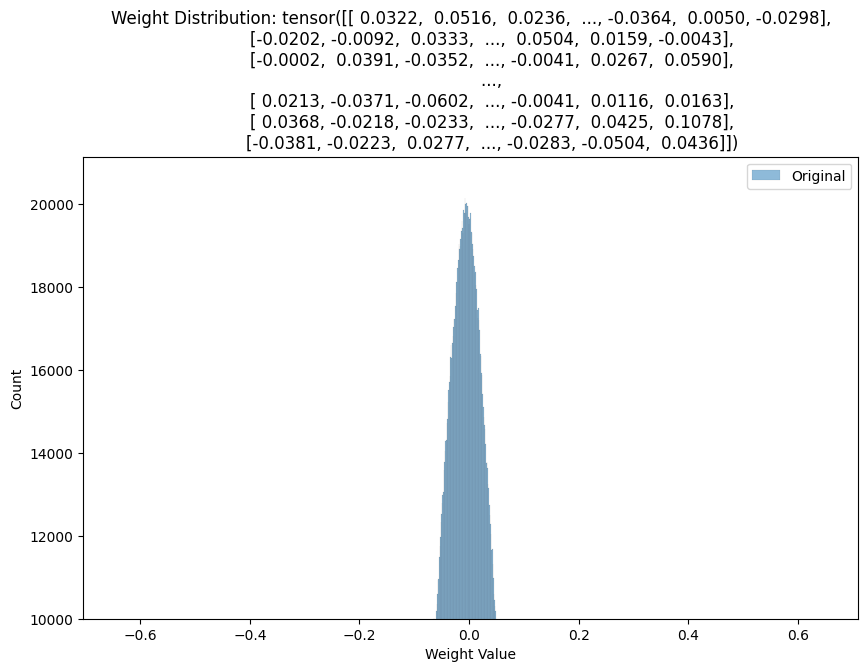

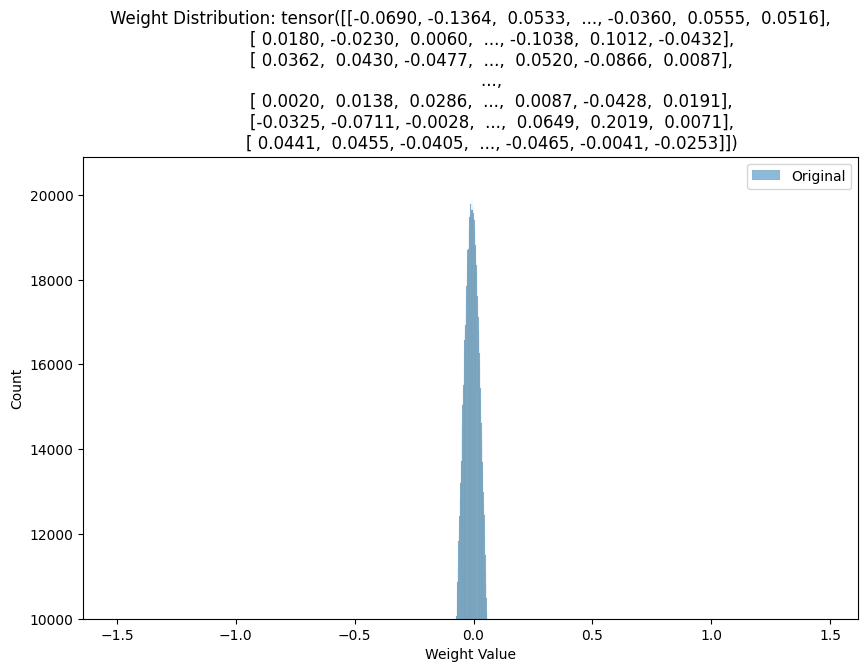

In [28]:
analyzer._register_hooks_meter(2)
analyzer._register_hooks_vilt(0)
analyzer.forward(meter_model, vilt_model, meter_batch, vilt_batch)
# Analyze and visualize the outputs
meter_stats, vilt_stats = analyzer.analyze_outputs()

meter_weights_intermediate = _get_weights(analyzer.meter_model, "text_transformer.encoder.layer.2.intermediate.dense")
meter_weights_output = _get_weights(analyzer.meter_model, "text_transformer.encoder.layer.2.output.dense")

vilt_weights_fc1 = _get_weights(analyzer.vilt_model, "transformer.blocks.0.mlp.fc1")
vilt_weights_fc2 = _get_weights(analyzer.vilt_model, "transformer.blocks.0.mlp.fc2")

plot_weight_distributions(meter_weights_intermediate, meter_weights_output, "METER")
plot_weight_distributions(vilt_weights_fc1, vilt_weights_fc2, "ViLT")

Forwarding the models
Meter model
Image token type 1
Image token type 2
VILT model
Image token type 1
Image token type 2
METER output statistics:
  mean: 0.022731
  std: 0.723141
  min: -12.305448
  max: 15.110385
  abs_mean: 0.284766

ViLT output statistics:
  mean: 11.986362
  std: 42.835369
  min: -3133.068115
  max: 1778.835205
  abs_mean: 20.150915

Estimated scale factor (ViLT/METER): 70.763046
Current ViLT scale_factor parameter: 1.000000


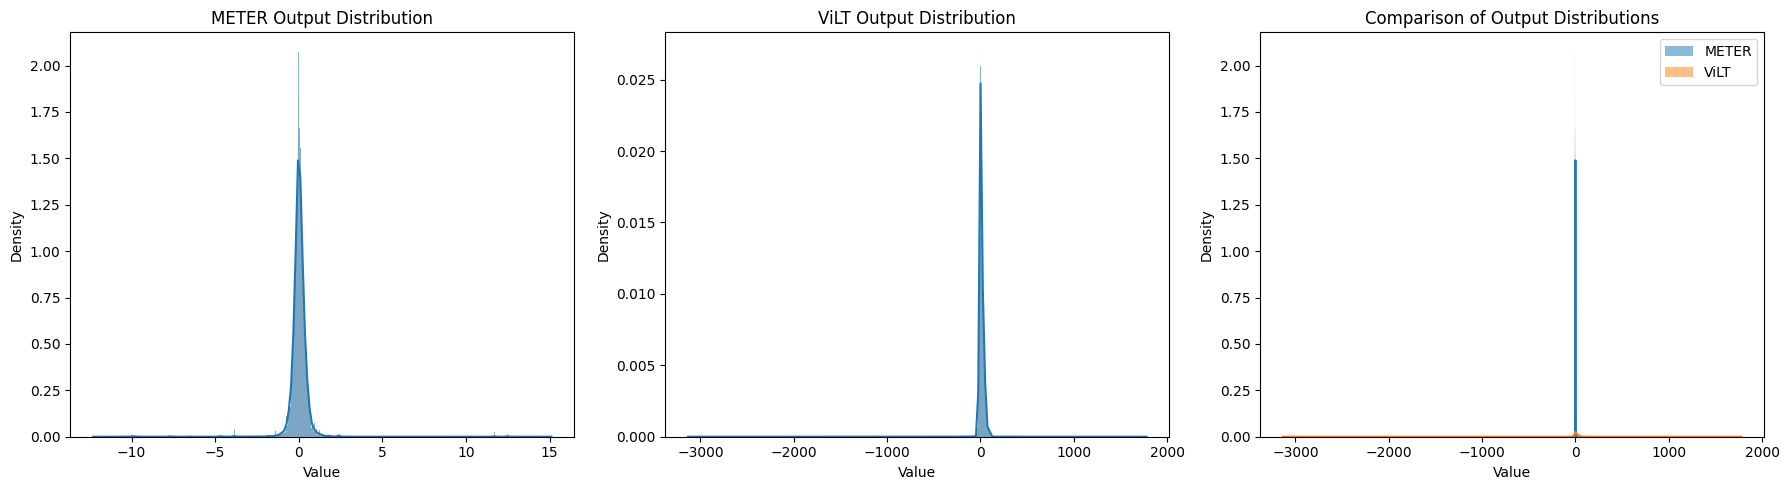

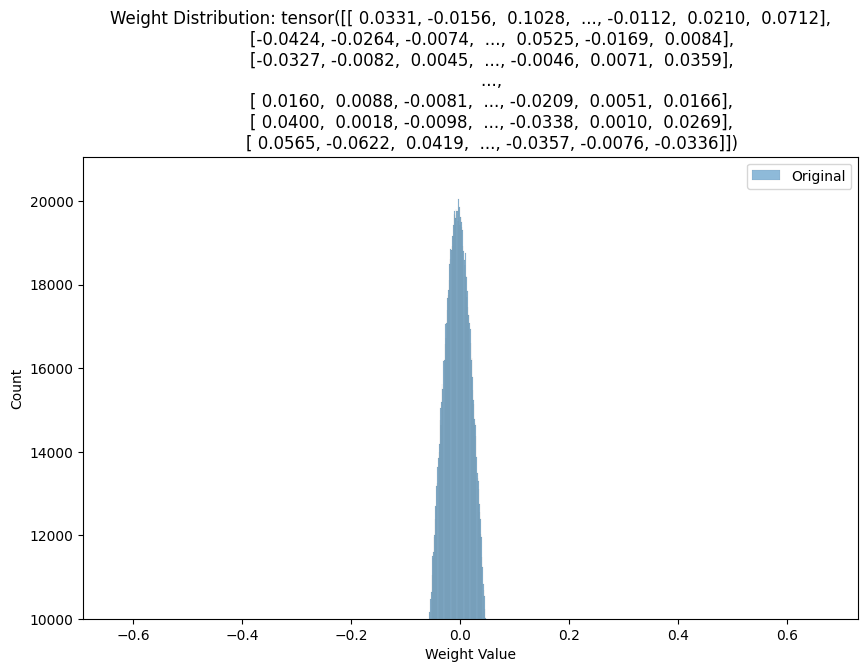

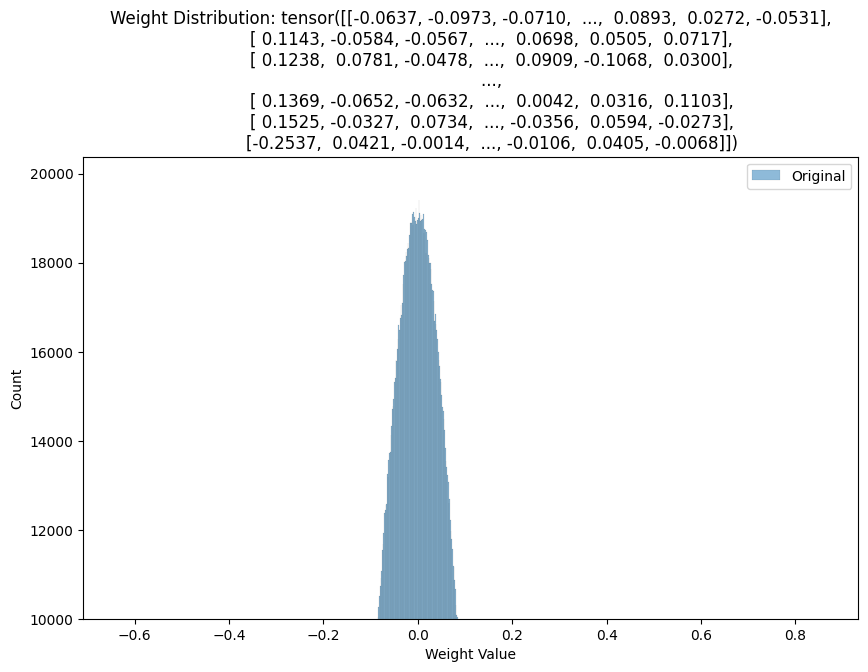

In [29]:
analyzer._register_hooks_meter(6)
analyzer._register_hooks_vilt(6)
analyzer.forward(meter_model, vilt_model, meter_batch, vilt_batch)
# Analyze and visualize the outputs
meter_stats, vilt_stats = analyzer.analyze_outputs()

meter_weights_intermediate = _get_weights(analyzer.meter_model, "text_transformer.encoder.layer.6.intermediate.dense")
meter_weights_output = _get_weights(analyzer.meter_model, "text_transformer.encoder.layer.6.output.dense")

vilt_weights_fc1 = _get_weights(analyzer.vilt_model, "transformer.blocks.6.mlp.fc1")
vilt_weights_fc2 = _get_weights(analyzer.vilt_model, "transformer.blocks.6.mlp.fc2")

plot_weight_distributions(meter_weights_intermediate, meter_weights_output, "METER")
plot_weight_distributions(vilt_weights_fc1, vilt_weights_fc2, "ViLT")

Forwarding the models
Meter model
Image token type 1
Image token type 2
VILT model
Image token type 1
Image token type 2
METER output statistics:
  mean: 0.022731
  std: 0.723141
  min: -12.305448
  max: 15.110385
  abs_mean: 0.284766

ViLT output statistics:
  mean: 10.243385
  std: 43.053272
  min: -3445.722168
  max: 2024.042725
  abs_mean: 18.820766

Estimated scale factor (ViLT/METER): 66.092026
Current ViLT scale_factor parameter: 1.000000


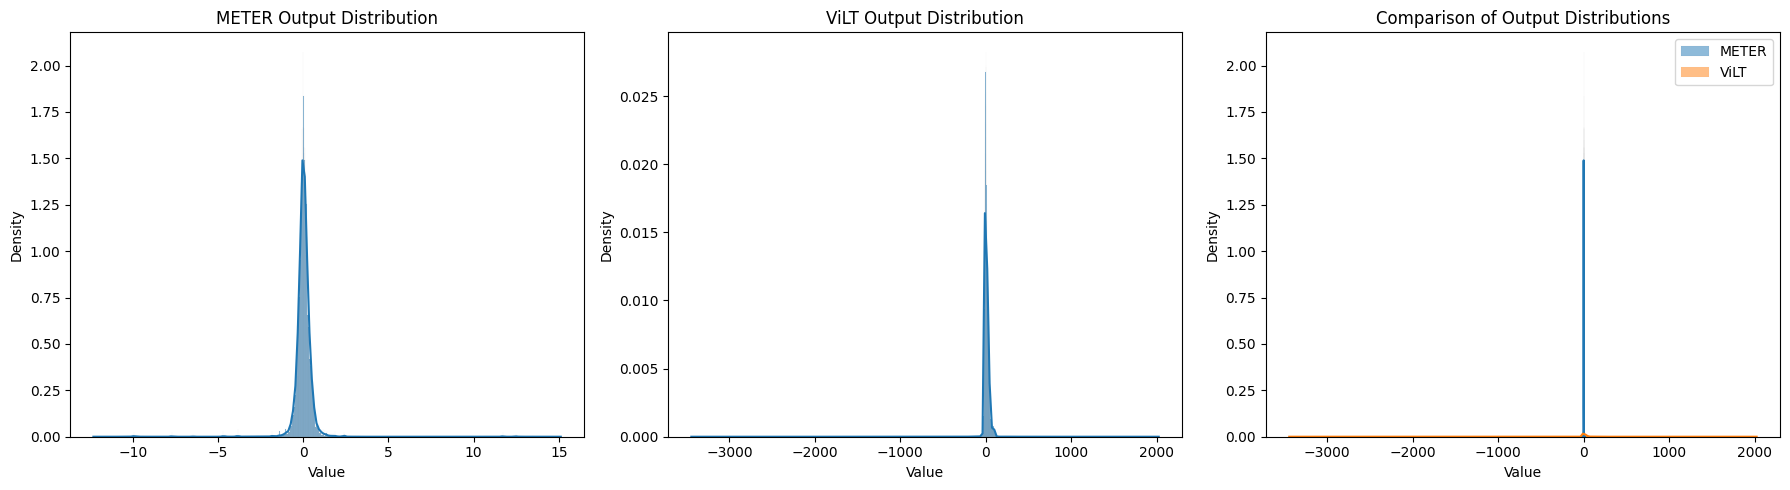

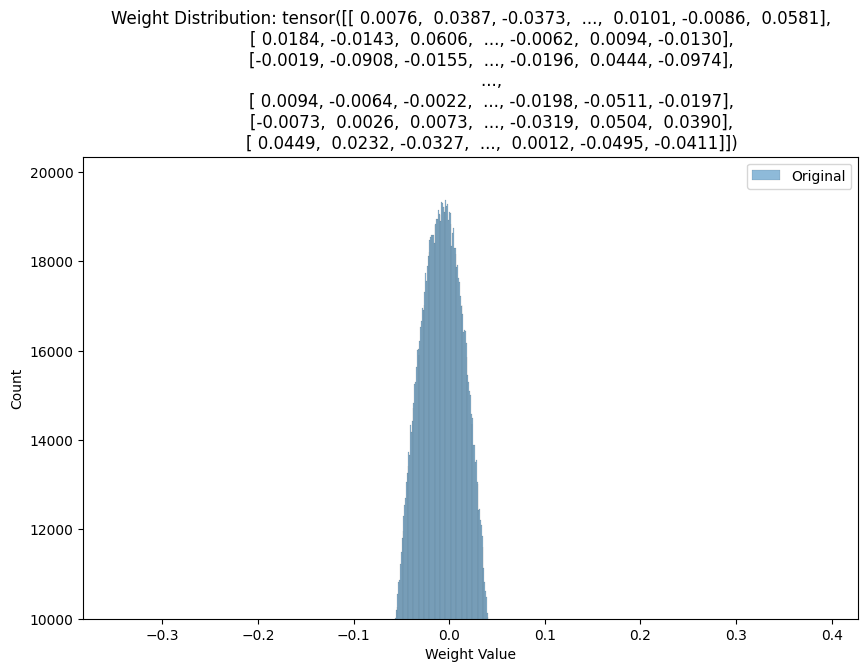

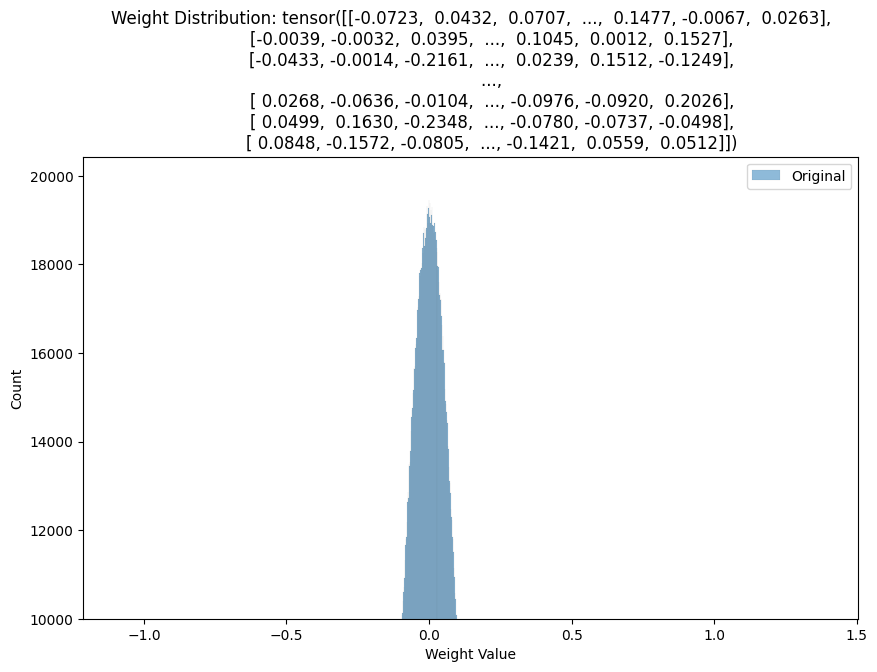

In [30]:
analyzer._register_hooks_meter(11)
analyzer._register_hooks_vilt(11)
analyzer.forward(meter_model, vilt_model, meter_batch, vilt_batch)
# Analyze and visualize the outputs
meter_stats, vilt_stats = analyzer.analyze_outputs()

meter_weights_intermediate = _get_weights(analyzer.meter_model, "text_transformer.encoder.layer.11.intermediate.dense")
meter_weights_output = _get_weights(analyzer.meter_model, "text_transformer.encoder.layer.11.output.dense")

vilt_weights_fc1 = _get_weights(analyzer.vilt_model, "transformer.blocks.11.mlp.fc1")
vilt_weights_fc2 = _get_weights(analyzer.vilt_model, "transformer.blocks.11.mlp.fc2")

plot_weight_distributions(meter_weights_intermediate, meter_weights_output, "METER")
plot_weight_distributions(vilt_weights_fc1, vilt_weights_fc2, "ViLT")

# Quantized Outputs

In [10]:
from quantization_utils import quantize_modules
# Quantize the METER model
meter_quantized = copy.deepcopy(meter_model)
meter_quantized.kd_layer = 2
meter_quantized.eval()

# Quantize the ViLT model
vilt_quantized = copy.deepcopy(vilt_model)
vilt_quantized.kd_layer = 0
vilt_quantized.eval()


# Define the modeules to train
meter_quant_layers = {'layer_names': ["text_transformer.encoder.layer.2.intermediate.dense",
                                    "text_transformer.encoder.layer.2.output.dense"],
                    'kd_layer': 2}

vilt_quant_layers = {'layer_names': ["transformer.blocks.0.mlp.fc1",
                                    "transformer.blocks.0.mlp.fc2"],
                        'kd_layer': 0}

# Quantize the METER model
meter_quant = quantize_modules(meter_quantized, meter_quant_layers['layer_names'], 4)

# Quantize the ViLT model
vilt_quant = quantize_modules(vilt_quantized, vilt_quant_layers['layer_names'], 4)

{'text_transformer.encoder.layer.2.intermediate.dense': QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.PlaceholderObserver'>, dtype=torch.quint8, quant_min=0, quant_max=15, is_dynamic=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric, quant_min=-8, quant_max=7, reduce_range=False){}), 'text_transformer.encoder.layer.2.output.dense': QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.PlaceholderObserver'>, dtype=torch.quint8, quant_min=0, quant_max=15, is_dynamic=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric, quant_min=-8, quant_max=7, reduce_range=False){})}
{'transformer.blocks.0.mlp.fc1': QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.PlaceholderObserver'>, dtype=torch.quint8, quant_min=0, quant_max=15, is_dynam